**Import required libraries**

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expressions and string processing
import re
import string

# Model persistence
import pickle

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ==== NLP Libraries ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download essential NLTK resources (run once, comment out after first run)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Set up plot aesthetics for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Loading the dataset**

In [ ]:
# Load datasets
train_data = pd.read_csv('/content/train.csv', encoding='latin1')
test_data = pd.read_csv('/content/test.csv', encoding='latin1')

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (27481, 10)
Test data shape: (4815, 9)


**Display first 5 rows**

In [ ]:
# Preview the first few rows of the training data
print("\nFirst 5 rows of training data:")
display(train_data.head())


First 5 rows of training data:


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


**Checking null values**

In [ ]:
# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())


Missing values in training data:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

Missing values in test data:
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


**Dispaly the columns**

In [ ]:
# Sentiment distribution in training data
print("\nSentiment distribution in training data:")
print("Columns in train_data:", train_data.columns)


Sentiment distribution in training data:
Columns in train_data: Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')


**Sentiment distribution**

In [ ]:
# Sentiment distribution in training data
print("\nSentiment distribution in training data:")
print(train_data['sentiment'].value_counts())


Sentiment distribution in training data:
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


**Bar chart visualiztion**

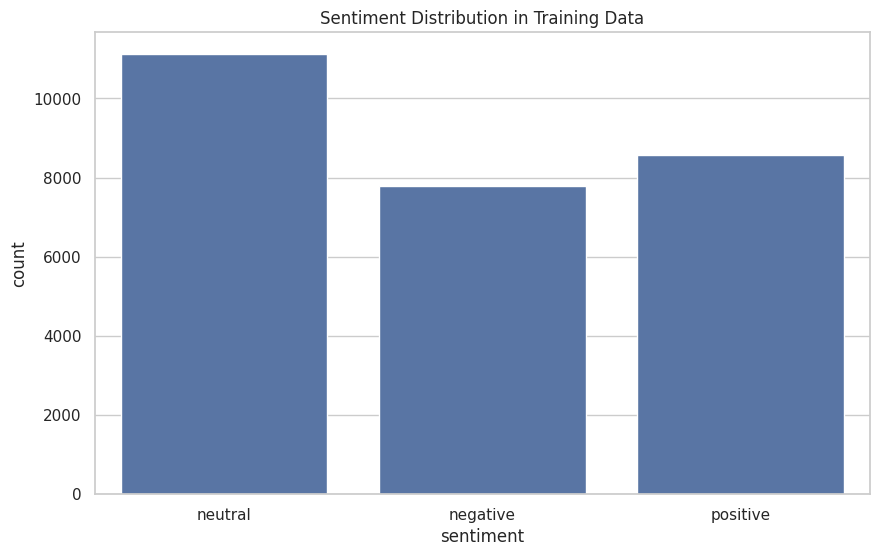

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_data)
plt.title('Sentiment Distribution in Training Data')
plt.show()

# --- Teaching Note ---
# It's important to check for missing values and understand the sentiment distribution.
# Now, let's check for any issues before analyzing text length.

**Analysis :-**
This bar chart means, In my dataset there are near about 15000 neutral tweets,near about 8000 negative tweets, near about 9000 positive tweets.

**Convert into string**

In [ ]:
# Convert 'text' to string to avoid errors with NaN (float) values
train_data['text'] = train_data['text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

**Curve chart**

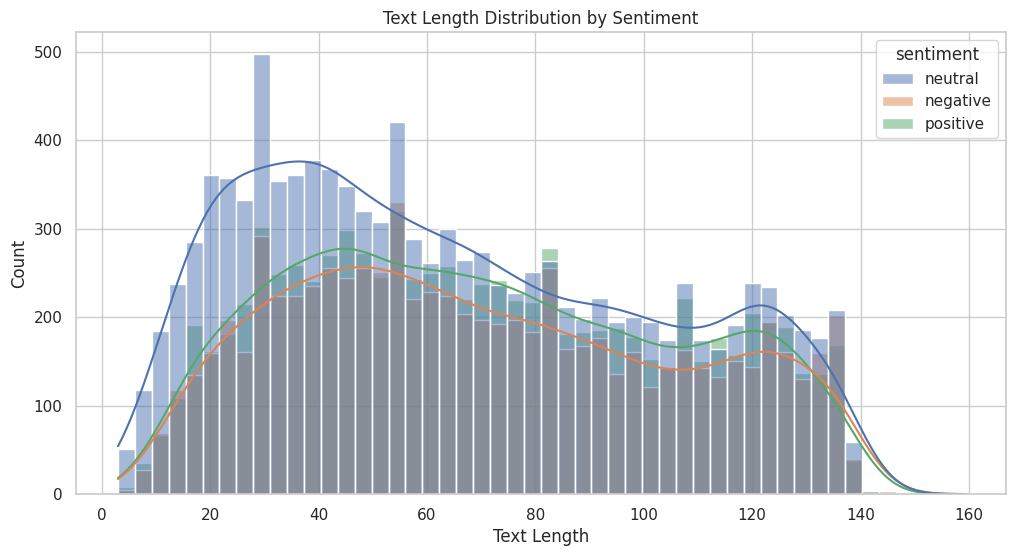

In [ ]:
# Explore text length distribution
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='text_length', hue='sentiment', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.show()

# --- Teaching Note ---
# By converting the 'text' column to string, we avoid TypeError when text is missing (NaN).
# Visualizing text length helps us spot outliers, very short or long texts, which may affect preprocessing or model performance.

**Analysis :-**
This above graph explains the text length means no of letters of positive, negative and neutral tweets of my daatset.

**Cleaning of data**

In [ ]:
# Clean and preprocess text before modeling to remove noise and standardize the input.
# This pipeline covers: lowercasing, removing URLs, HTML, mentions, hashtags, punctuation, numbers, and extra whitespace.
# Tokenization, stopword removal, and lemmatization are also included for robust NLP.

def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

**Preprocessing the daatset**

In [ ]:
# --- Teaching Note ---
# This can be a slow process on large datasets. Consider using tqdm for a progress bar in production!

print("Preprocessing training data (this may take a few minutes)...")
train_data['processed_text'] = train_data['text'].apply(preprocess_text)

print("Preprocessing test data (this may take a few minutes)...")
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Display examples of original vs processed text
print("\nOriginal vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {train_data.iloc[i]['text']}")
    print(f"Processed: {train_data.iloc[i]['processed_text']}")
    print("---")

# --- Teaching Note ---
# Why do we preprocess?
# - Removes noise (URLs, HTML, mentions, etc.)
# - Standardizes input for the model
# - Improves model performance, especially for traditional ML models
# Next steps: Feature extraction (vectorization)!

Preprocessing training data (this may take a few minutes)...
Preprocessing test data (this may take a few minutes)...

Original vs Processed Text Examples:
Original:  I`d have responded, if I were going
Processed: id responded going
---
Original:  Sooo SAD I will miss you here in San Diego!!!
Processed: sooo sad miss san diego
---
Original: my boss is bullying me...
Processed: bos bullying
---


**Sentiments as numbers**

In [ ]:
# --- Teaching Note ---
# Sentiment labels sometimes appear as text ("positive", "neutral", "negative") or as numbers (0, 2, 4).
# It's important to standardize them for modeling. Here, we'll ensure all are encoded as numbers.

sentiment_mapping = {'negative': 0, 'neutral': 2, 'positive': 4}

# Check if sentiment column contains text labels or numerical values
if train_data['sentiment'].dtype == 'object':
    train_data['sentiment_encoded'] = train_data['sentiment'].map(sentiment_mapping)
    test_data['sentiment_encoded'] = test_data['sentiment'].map(sentiment_mapping)
else:
    # If they're already numerical, just copy them
    train_data['sentiment_encoded'] = train_data['sentiment']
    test_data['sentiment_encoded'] = test_data['sentiment']

**Drop the missing values**

In [ ]:
# --- Teaching Note ---
# Why handle missing values in the test set?
# If there are any missing texts or labels, they can cause errors in evaluation. We drop those rows.
test_data = test_data.dropna(subset=['text', 'sentiment'])

**Training testing and spliting the dataset**

In [ ]:
# Split the training data into training and validation sets for model evaluation
# Stratify ensures each sentiment class is represented proportionally in both sets.
X_train, X_val, y_train, y_val = train_test_split(
    train_data['processed_text'],
    train_data['sentiment_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_data['sentiment_encoded']
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

# --- Teaching Note ---
# Always stratify when splitting classification data to maintain class balance in both sets.
# Now, we're ready for feature extraction and model training!

Training set size: 21984
Validation set size: 5497


**Training the model**

In [ ]:
# --- Teaching Note ---
# We'll train multiple models using different feature extraction techniques (Count Vectors and TF-IDF).
# This function automates training, evaluation, and visualization for each model.

def train_evaluate_model(model_name, vectorizer, classifier, X_train, y_train, X_val, y_val):
    """
    Train and evaluate a text classification model.

    Args:
        model_name (str): Name of the model for reporting
        vectorizer: Text vectorizer (CountVectorizer or TfidfVectorizer)
        classifier: Classifier model
        X_train, y_train: Training data
        X_val, y_val: Validation data

    Returns:
        tuple: Trained pipeline and accuracy score
    """
    # Create a pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Train the model
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()  # <--- Show directly in notebook instead of saving
    # plt.savefig(f'confusion_matrix_{model_name}.png')  # Not needed in Jupyter
    # plt.close()

    return pipeline, accuracy

**Models initialization**

In [ ]:
# Define vectorizers
count_vectorizer = CountVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Define models to try
models = [
    ('Logistic Regression with Count Vectors', count_vectorizer, LogisticRegression(max_iter=1000, C=1.0)),
    ('Logistic Regression with TF-IDF', tfidf_vectorizer, LogisticRegression(max_iter=1000, C=1.0)),
    ('Naive Bayes with Count Vectors', count_vectorizer, MultinomialNB()),
    ('Naive Bayes with TF-IDF', tfidf_vectorizer, MultinomialNB()),
    ('Linear SVC with TF-IDF', tfidf_vectorizer, LinearSVC(max_iter=1000)),
    ('Random Forest with TF-IDF', tfidf_vectorizer, RandomForestClassifier(n_estimators=100))
]

**Training and evaluating each model**

Training Logistic Regression with Count Vectors...
Logistic Regression with Count Vectors Accuracy: 0.6902

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1556
           2       0.63      0.74      0.68      2224
           4       0.77      0.70      0.73      1717

    accuracy                           0.69      5497
   macro avg       0.70      0.68      0.69      5497
weighted avg       0.70      0.69      0.69      5497



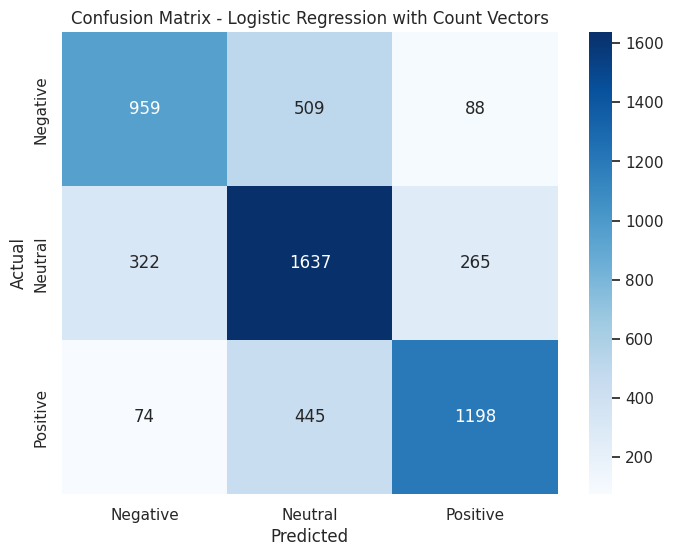

Training Logistic Regression with TF-IDF...
Logistic Regression with TF-IDF Accuracy: 0.6924

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1556
           2       0.62      0.76      0.69      2224
           4       0.78      0.68      0.73      1717

    accuracy                           0.69      5497
   macro avg       0.71      0.68      0.69      5497
weighted avg       0.70      0.69      0.69      5497



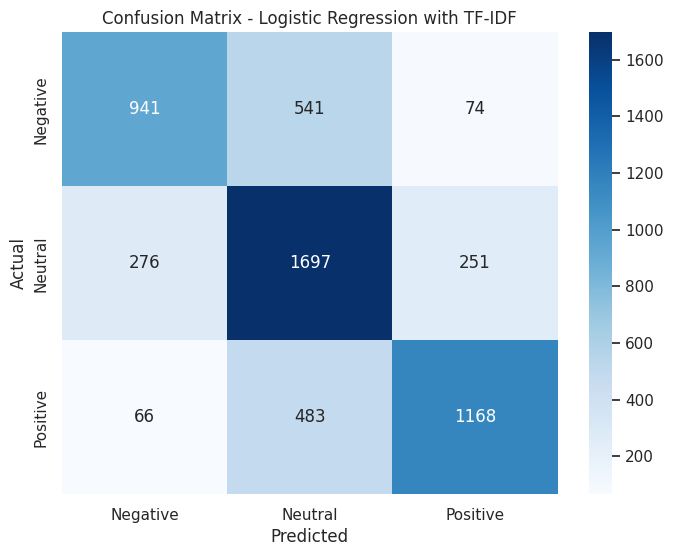

Training Naive Bayes with Count Vectors...
Naive Bayes with Count Vectors Accuracy: 0.6554

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.65      1556
           2       0.60      0.68      0.64      2224
           4       0.71      0.67      0.69      1717

    accuracy                           0.66      5497
   macro avg       0.67      0.65      0.66      5497
weighted avg       0.66      0.66      0.66      5497



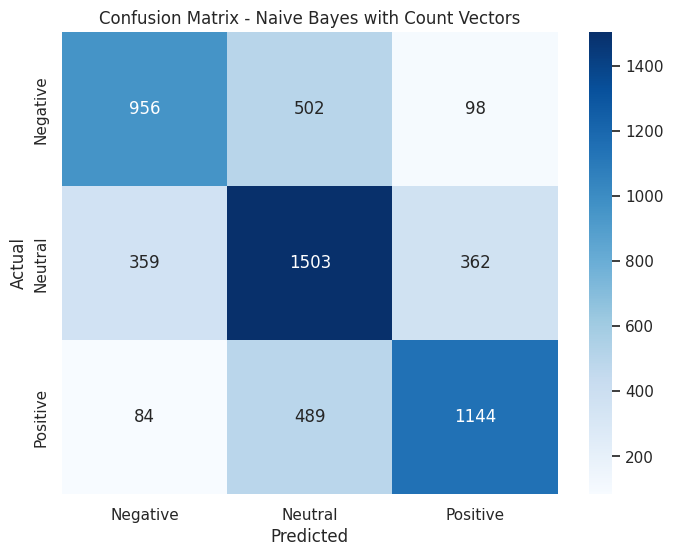

Training Naive Bayes with TF-IDF...
Naive Bayes with TF-IDF Accuracy: 0.6318

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59      1556
           2       0.55      0.77      0.64      2224
           4       0.73      0.58      0.65      1717

    accuracy                           0.63      5497
   macro avg       0.67      0.61      0.63      5497
weighted avg       0.66      0.63      0.63      5497



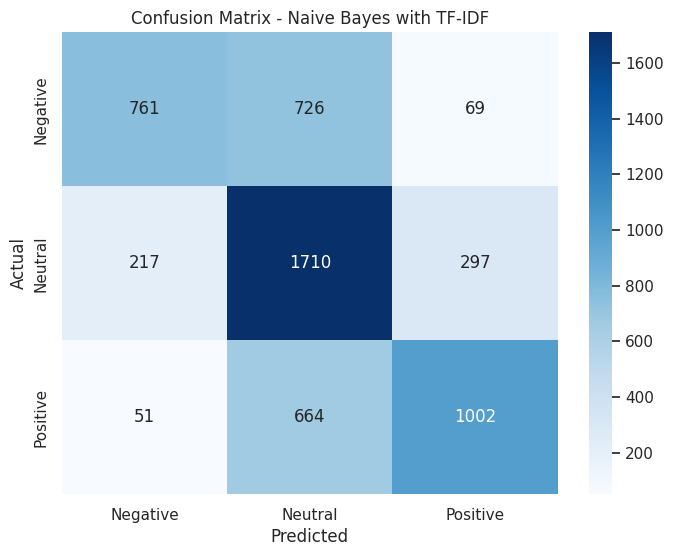

Training Linear SVC with TF-IDF...
Linear SVC with TF-IDF Accuracy: 0.6762

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      1556
           2       0.63      0.69      0.66      2224
           4       0.74      0.70      0.72      1717

    accuracy                           0.68      5497
   macro avg       0.68      0.67      0.68      5497
weighted avg       0.68      0.68      0.68      5497



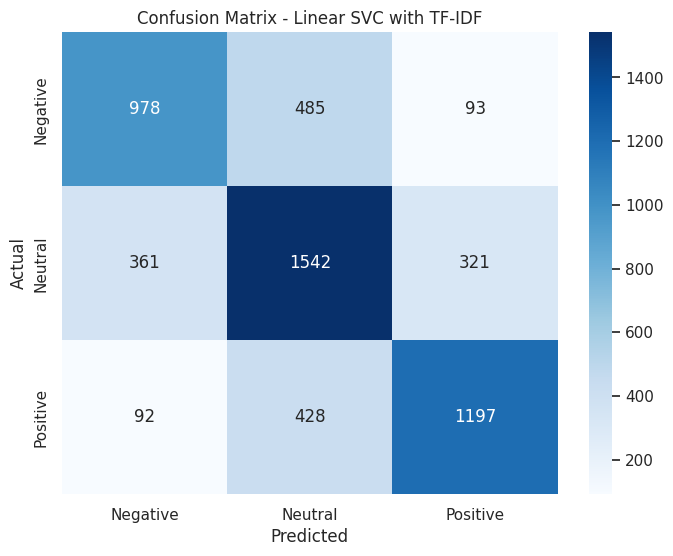

Training Random Forest with TF-IDF...
Random Forest with TF-IDF Accuracy: 0.7053

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      1556
           2       0.65      0.74      0.70      2224
           4       0.75      0.74      0.75      1717

    accuracy                           0.71      5497
   macro avg       0.72      0.70      0.70      5497
weighted avg       0.71      0.71      0.70      5497



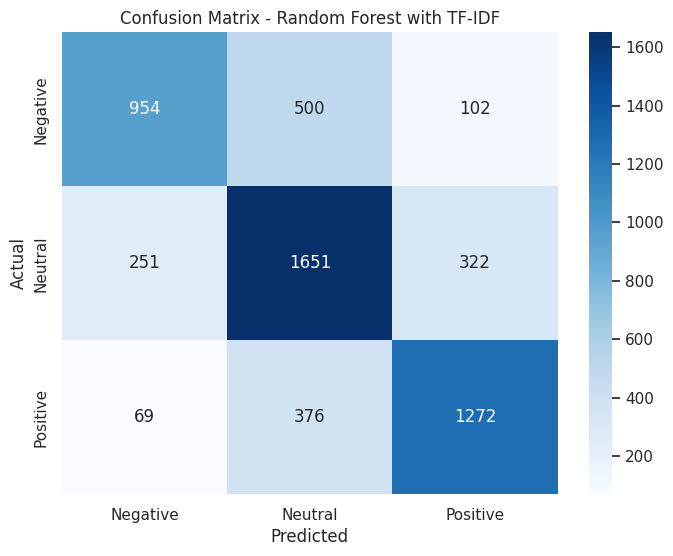

In [ ]:
# Train and evaluate each model
results = {}
for model_name, vectorizer, classifier in models:
    pipeline, accuracy = train_evaluate_model(
        model_name, vectorizer, classifier, X_train, y_train, X_val, y_val
    )
    results[model_name] = (pipeline, accuracy)

**Accuracy score of each model**

In [ ]:
# --- Teaching Note ---
# After identifying the best model, let's dive deeper into its strengths and weaknesses.
# We'll look at per-class F1-scores and examine misclassified examples for further insights.

# Find the best model based on accuracy
best_model_name = None
best_accuracy = -1

for name, (pipeline, accuracy) in results.items():
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

print(f"\nBest performing model: {best_model_name} with accuracy {best_accuracy:.4f}")
# Get the best model pipeline
best_pipeline = results[best_model_name][0]

# Make predictions on the validation set
y_val_pred = best_pipeline.predict(X_val)

def detailed_evaluation(y_true, y_pred, model_name):
    """
    Perform detailed evaluation of model performance

    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model for reporting
    Returns:
        pd.DataFrame: Classification report as DataFrame
    """
    # Classification report (as DataFrame for easy plotting)
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print(f"Detailed evaluation for {model_name}:")
    display(report_df)

    # Visualize F1-scores by class
    plt.figure(figsize=(10, 6))
    # Exclude 'accuracy', 'macro avg', 'weighted avg' from plot
    class_labels = ['0', '2', '4']  # Assuming 0=negative, 2=neutral, 4=positive
    sns.barplot(x=class_labels, y=report_df.loc[class_labels, 'f1-score'], palette="viridis")
    plt.title(f'F1 Scores by Class - {model_name}')
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.xlabel("Sentiment Class")
    plt.xticks([0, 1, 2], ['Negative (0)', 'Neutral (2)', 'Positive (4)'])
    plt.tight_layout()
    plt.show()  # Show plot in notebook
    # plt.savefig(f'{model_name}_f1_scores.png')  # Don't save in notebook context

    return report_df


Best performing model: Random Forest with TF-IDF with accuracy 0.7053


**Detailed evaluation**

Detailed evaluation for Random Forest with TF-IDF:


,precision,recall,f1-score,support
0,0.748823,0.613111,0.674205,1556.000000
2,0.653344,0.742356,0.695012,2224.000000
4,0.750000,0.740827,0.745385,1717.000000
accuracy,0.705294,0.705294,0.705294,0.705294
macro avg,0.717389,0.698765,0.704867,5497.000000
weighted avg,0.710561,0.705294,0.704856,5497.000000


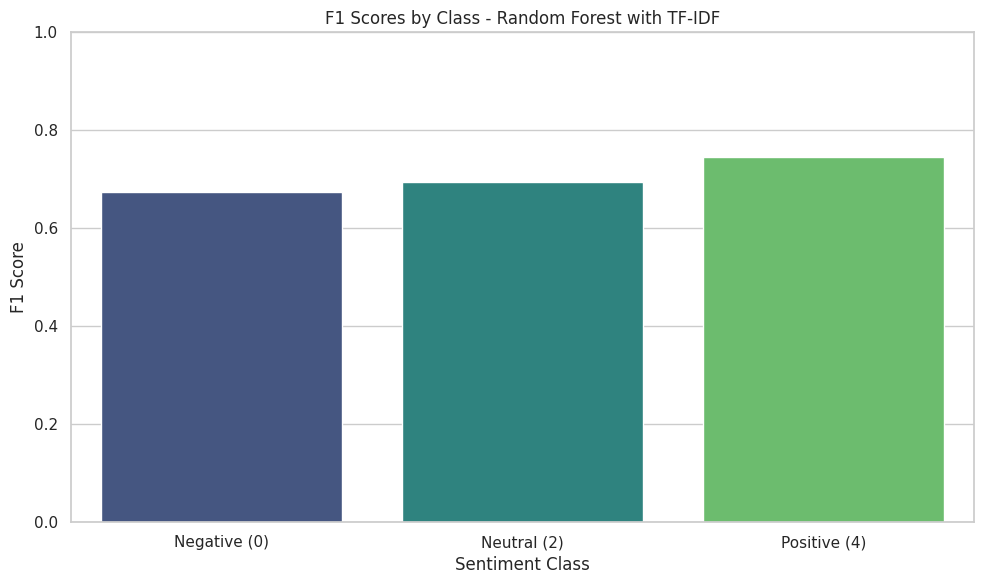

In [ ]:
# Perform detailed evaluation
detailed_results = detailed_evaluation(y_val, y_val_pred, best_model_name)

**Misclassified analysis**

In [ ]:
# --- Teaching Note ---
# Analyzing misclassified examples can reveal patterns such as ambiguous text, sarcasm, or class imbalance.
# This is a powerful step for error analysis and guiding further improvements.

# Find and analyze misclassified examples
misclassified_indices = np.where(y_val.values != y_val_pred)[0]
misclassified_examples = pd.DataFrame({
    'text': X_val.iloc[misclassified_indices].values,
    'true_sentiment': y_val.iloc[misclassified_indices].values,
    'predicted_sentiment': y_val_pred[misclassified_indices]
})

print("\nSample of misclassified examples:")
display(misclassified_examples.head(10))


Sample of misclassified examples:


,text,true_sentiment,predicted_sentiment
0,awww bb sound lonely want drive therefly snuggle,0,2
1,dont worried im safe sound,4,0
2,getting ready goingaway dessert reception coll...,2,4
3,think disgusting,0,2
4,babysitting kid wont let play wii,0,2
5,seems really quiet tonightam jealous clearly e...,2,0
6,thers many peole tweeting tonight well suppose...,0,2
7,admit im bit bummed wasnt friend walking today,0,2
8,good morninghoping throw back coffee like right,2,4
9,haha co one tweet smile smile smile quoted boy...,4,2


**Saving the model**

In [ ]:
# --- Teaching Note ---
# Saving your trained model lets you reuse it for future predictions without retraining.
# We'll use pickle to serialize (save) and deserialize (load) our pipeline.
# We'll also write a helper function to make predictions on any new text.

import pickle

def save_model(model, filename):
    """
    Save a trained model to a file.

    Args:
        model: Trained model to save
        filename: Filename to save the model
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

# Save the best model
model_filename = 'sentiment_analysis_model.pkl'
save_model(best_pipeline, model_filename)

def load_model(filename):
    """
    Load a trained model from a file.

    Args:
        filename: Filename to load the model from

    Returns:
        Loaded model
    """
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def predict_sentiment(text, model):
    """
    Predict sentiment for new text.

    Args:
        text (str): Input text
        model: Trained model

    Returns:
        int: Predicted sentiment (0=negative, 2=neutral, 4=positive)
    """
    # Preprocess the text using the same function as before
    processed_text = preprocess_text(text)
    # Make prediction
    return model.predict([processed_text])[0]

Model saved to sentiment_analysis_model.pkl


**Input taking**

In [ ]:
# --- Teaching Note ---
# Always preprocess new text using the same steps as during training!
# The pipeline expects input in the same format as it was trained on.

# Test the prediction function with some examples
loaded_model = load_model(model_filename)

test_texts = [
    "I absolutely love this product! It's amazing!",
    "The service was okay, nothing special.",
    "This is the worst experience I've ever had. Terrible customer service."
]

print("\nTesting model on new examples:")
for text in test_texts:
    sentiment = predict_sentiment(text, loaded_model)
    sentiment_label = {0: "Negative", 2: "Neutral", 4: "Positive"}.get(sentiment, "Unknown")
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment_label} ({sentiment})")
    print("---")

# --- Teaching Note ---
# You can now reuse this model in web apps, REST APIs, or batch predictions!
# Make sure to ship the same preprocessing code and dependencies with your deployment.


Testing model on new examples:
Text: I absolutely love this product! It's amazing!
Predicted sentiment: Positive (4)
---
Text: The service was okay, nothing special.
Predicted sentiment: Neutral (2)
---
Text: This is the worst experience I've ever had. Terrible customer service.
Predicted sentiment: Negative (0)
---


**User input**

In [ ]:
# --- Teaching Note ---
# This is a very simple way to get one input from the user and predict its sentiment.

# Load the model (if not already loaded in the current session)
# loaded_model = load_model(model_filename) # Uncomment this line if needed

user_input_text = input("Enter text for sentiment analysis: ")

if user_input_text:
    # Predict sentiment
    predicted_sentiment_value = predict_sentiment(user_input_text, loaded_model)

    # Map numerical sentiment back to a label
    sentiment_label = {0: "Negative", 2: "Neutral", 4: "Positive"}.get(predicted_sentiment_value, "Unknown")

    print(f"Predicted sentiment: {sentiment_label} ({predicted_sentiment_value})")
else:
    print("No text entered.")

Enter text for sentiment analysis: i love this product! It's amazing!
Predicted sentiment: Positive (4)
